# simple 6D PS reconstruction

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan_2screens
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.utils import split_2screen_dset
from phase_space_reconstruction.train import train_3d_scan_2screens

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

from analysis_scripts import plot_3d_scan_data_2screens, plot_3d_scan_data_2screens_contour, create_clipped_dset

## Load data

In [5]:
# load data
data_dir = '/global/cfs/cdirs/m669/rroussel/AWA_DATA/01_18_6D_PSR/reconstruction_scan'
#data_dir = '/Users/jpga/AWA_DATA/01_16_6D_PSR/reconstruction_scan'
save_dir =  '/global/cfs/cdirs/m669/rroussel/AWA_DATA/01_18_6D_PSR/reconstruction_results/scan_5'
dset = torch.load(os.path.join(data_dir, 'dset_01_18_scan_5.pt'))

In [6]:
# clip dset
width = 300
clipped_dset = create_clipped_dset(dset, width)
clipped_dset.images.shape
torch.save(clipped_dset, os.path.join(save_dir, 'dset_01_18_scan_5_clipped.pt'))

In [4]:
# max intensity
vmax1 = clipped_dset.images[4,0,0].max()
print(vmax1)
vmax2 = clipped_dset.images[4,0,1].max()
print(vmax2)

tensor(0.0022, dtype=torch.float64)
tensor(0.0010, dtype=torch.float64)


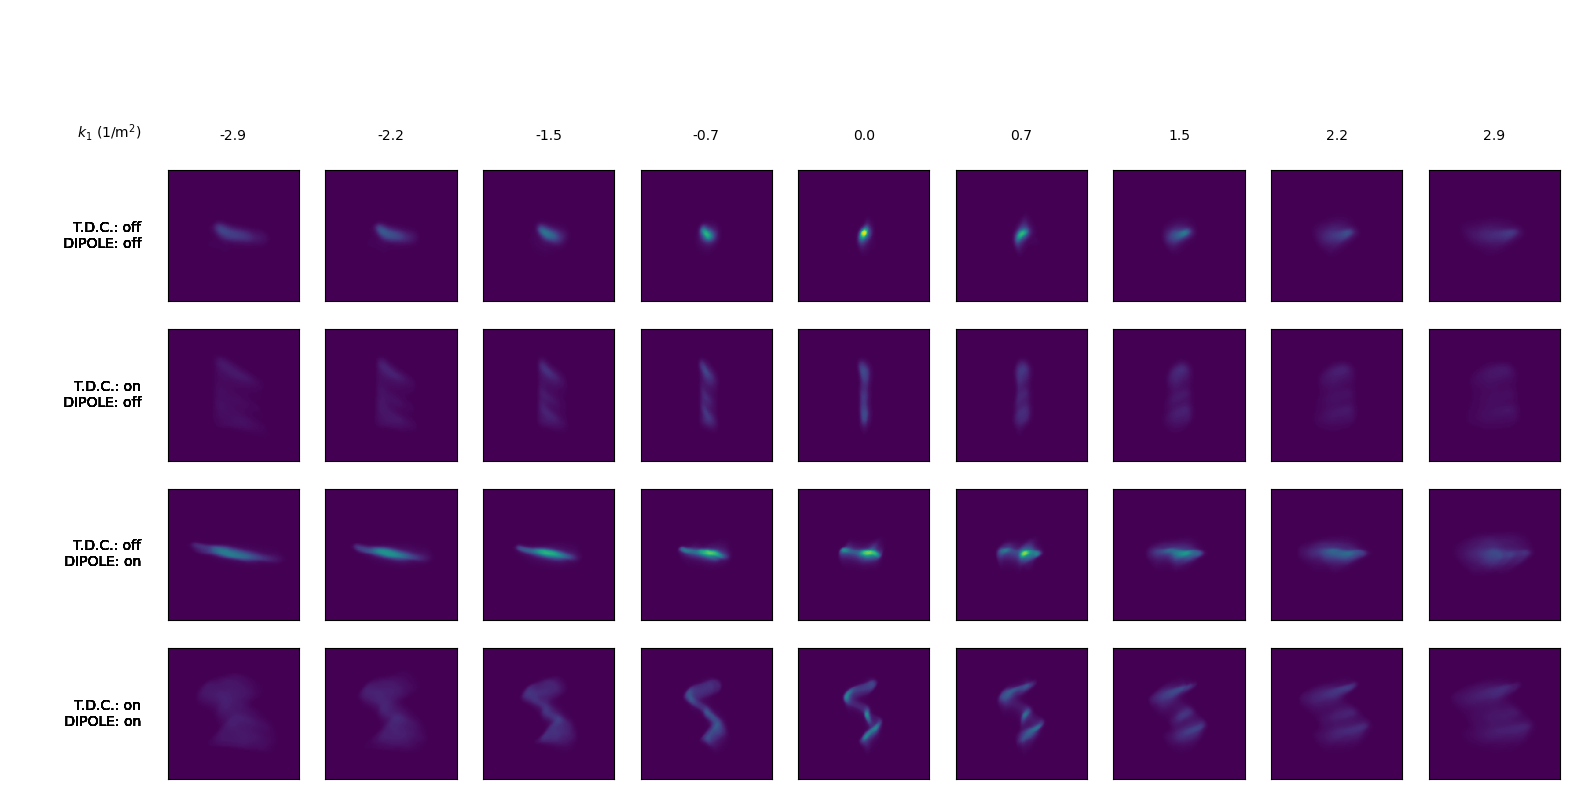

In [5]:
# plot all data
plot_3d_scan_data_2screens(clipped_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

In [6]:
# split dset into train and test
train_dset, test_dset = split_2screen_dset(clipped_dset)

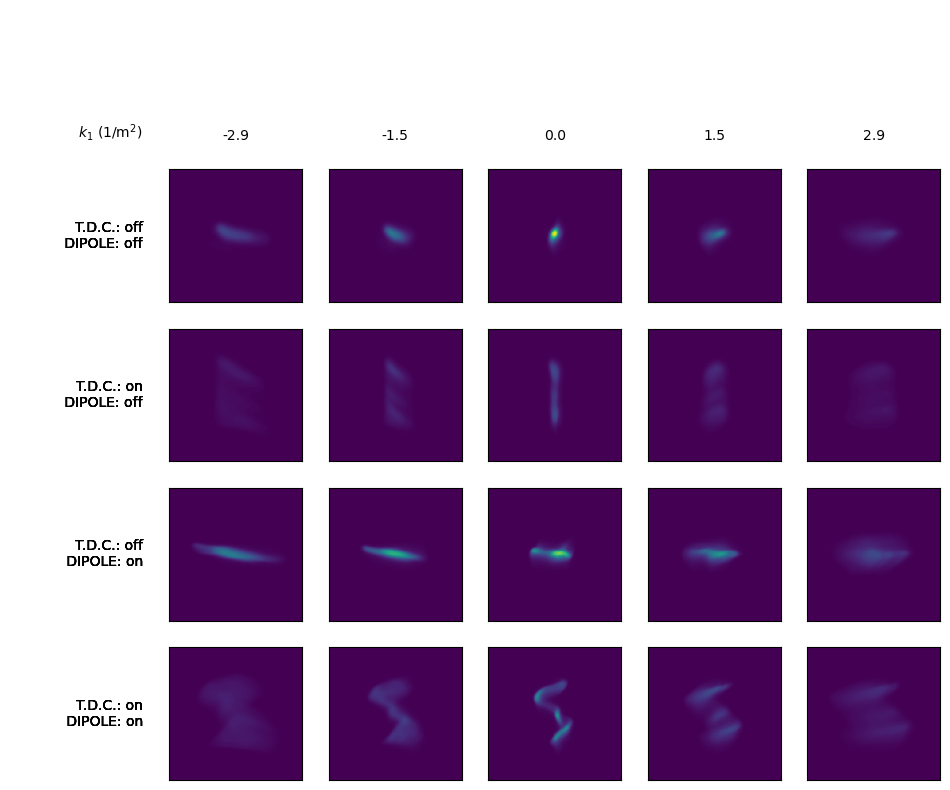

In [7]:
# plot train dset
plot_3d_scan_data_2screens(train_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

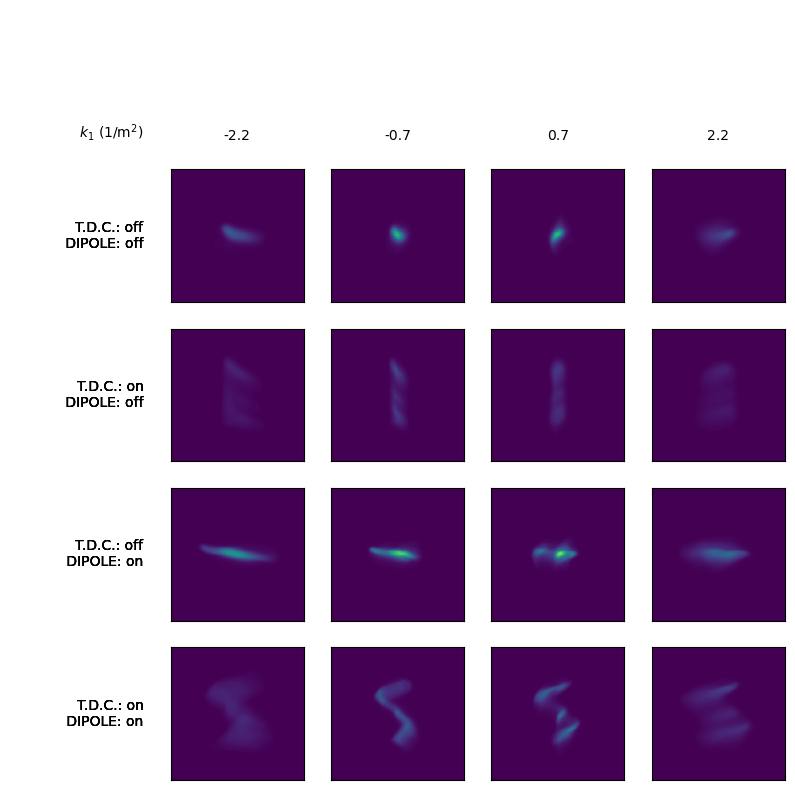

In [8]:
# plot test dset
plot_3d_scan_data_2screens(test_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

## Define diagnostics lattice parameters

In [9]:
# diagnostic beamline:
p0c = 43.3e6
lattice0 = quad_tdc_bend(p0c=p0c, dipole_on=False)
lattice1 = quad_tdc_bend(p0c=p0c, dipole_on=True)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [0, 2, 4] 

# create 2 diagnostic screens: 
def create_screen(size, pixels):
    bins = torch.linspace(-size/2, size/2, pixels)
    bandwidth = (bins[1]-bins[0]) / 2
    return ImageDiagnostic(bins, bins, bandwidth)

screen0 = create_screen(30.22*1e-3*width/700, width)
screen1 = create_screen(26.96*1e-3*width/700, width)

### 10,000 particles

In [14]:
%%time

# training
pred_beam = train_3d_scan_2screens(
    train_dset, 
    lattice0,
    lattice1, 
    p0c, 
    screen0,
    screen1,
    ids = scan_ids,
    n_epochs = 1_001, 
    n_particles = 10_000, 
    device = 'cuda',
    save_dir = save_dir,
    saving_interval = 1_000,
    )
pred_beam = pred_beam.numpy_particles()
torch.cuda.empty_cache()

Using device: cuda
0 tensor(1871642.6627, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
saving tmp_beam0.pt
100 tensor(646349.7635, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
200 tensor(621714.6251, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
300 tensor(613302.5926, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
400 tensor(601120.2047, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
500 tensor(592674.2330, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
600 tensor(588075.7708, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
700 tensor(602309.1860, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
800 tensor(581480.1184, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
900 tensor(580618.5410, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
1000 tensor(584156.8314, device=

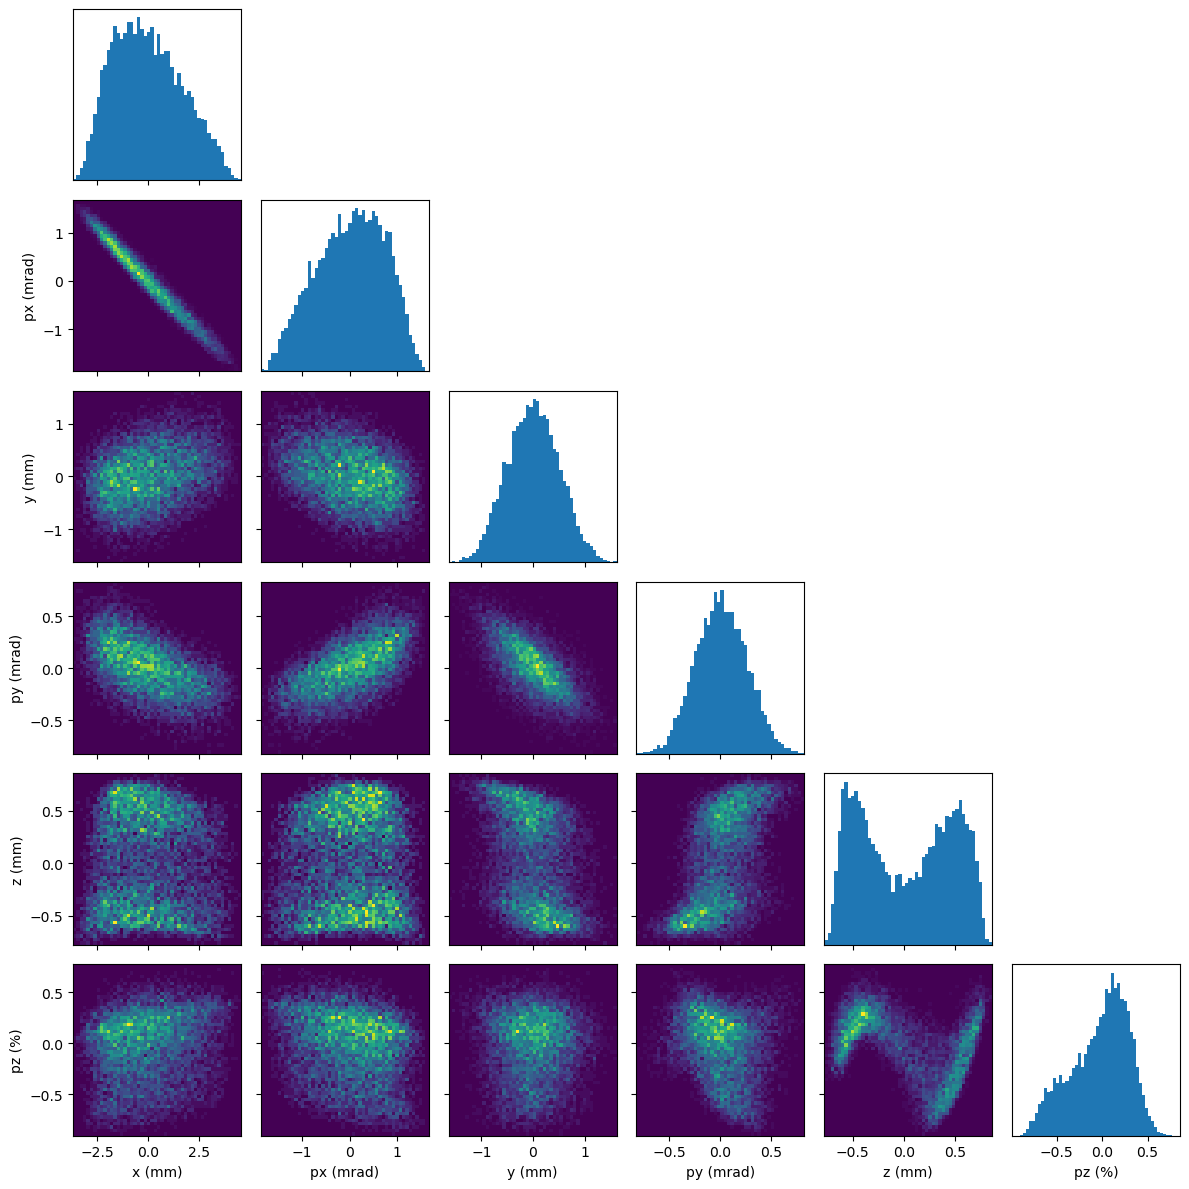

In [15]:
# reconstructed beam projections:
fig, ax = plot_projections(pred_beam,
                           #custom_lims = lims,
                           bins = 50
                           )
plt.show()

In [16]:
torch.save(pred_beam, os.path.join(save_dir, 'pred_beam.pt'))